<a href="https://colab.research.google.com/github/StevenWestmoreland/BuildWeek2ScotchDataset/blob/master/DSPT6_Unit2_Build_StevenWestmoreland.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Scotch Satisfaction Ratings

*The dataset that was used in this project can be found [here](https://www.kaggle.com/koki25ando/22000-scotch-whisky-reviews) on Kaggle. It was collected from Whisky Advocate by Kaggle user Andy II.*

Project synopsis: Can we predict whether a whisky can be considered Poor, Fair, Good, or Excellent based off of it's category, Whisky Advocate score, price, and the reviewer's description? 

*Note: This project uses scotch and whisky interchangably. While the author is aware that the wide world of whisky extends far beyond scotch alone, for this project we will just be looking at scotch whiskies and it is therefore inaccurate for use with bourbons, Japanese or Irish whiskies, or any other variation thereof.*

This project is designed with two major applications in mind, one for the consumer and one for the distiller.

For the consumer, it is my hope that this data can be useful in determining whether to give a whisky a try, While perhaps a bit unwieldy compared to directly consulting review sites such as Whisky Advocate, not all whiskies have reviews (or if they do there is a woefully small amount of them, which can bring into question how much partiality or bias went in to those scores.) Instead, by looking at the features used in these models and comparing them to prospective whiskies the consumer will be better armed in making an informed, and happily enjoyable, purchase. 

Similarly, for the distiller, these models will show which key features lead more often than not towards Excellent ratings. This will allow for the tailoring of future mash bill recipes in ways to capitalize on the taste preferences of the consumer base.

However, these models are limited in scope. They do not take into account things like mash bill recpie percentages, barrel aging processes, or other key phases of the distillation process. Neither are these models good for whiskies that have extensive reviews already, if for no other reason than it would be easier to consult a review site or app than it would to apply these models to the whisky in question.

My target therefore initially was pegged to be the review point score from Whisky Advocate, but for reasons I will explain below I instead opted to create a new feature I called satisfaction rating. This feature is a categorical description of score bands with four separate classes: **Excellent**, **Good**, **Fair**, and **Poor**. 

For the models themselves, I will be evaluating their performance on Accuracy, Precision, and Recall, as well as taking a look at sci-kit learn's classification report metric. As you will see shortly, Accuracy alone will prove inadequate due to the relative evenness of the classes (our baselines run from 20.1% to 27.7% on a random guess).

#Exploratory Analysis

In [1]:
# Imports and first dataset reading. Cleaned Index column and renamed column 
# 'review.point' to avoid any unnecessary issues with dot-notation.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install eli5
!pip install category_encoders==2.*
!pip install pdpbox

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 112kB 4.5MB/s 
     |████████████████████████████████| 81kB 3.4MB/s 
     |████████████████████████████████| 57.7MB 69kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=3000a94b9b5e3d48a27b9836cd3a8c2387617bf5471cd66cb701a1fc8eed6526
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [2]:
scotch_df=pd.read_csv('scotch_review.csv').drop(columns='Unnamed: 0')
scotch_df=scotch_df.rename(columns={'review.point': 'review_point'})
scotch_df.head()

,name,category,review_point,price,currency,description
0,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,$,"Magnificently powerful and intense. Caramels, ..."
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00,$,What impresses me most is how this whisky evol...
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00,$,There have been some legendary Bowmores from t...
3,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,$,With a name inspired by a 1926 Buster Keaton m...
4,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,$,"Captivating, enticing, and wonderfully charmin..."


In [3]:
# check for null values
scotch_df.isnull().sum()

name            0
category        0
review_point    0
price           0
currency        0
description     0
dtype: int64

Since we are looking at predicting how well a scotch might be recieved, I initially pegged the 'review_point' column as my target variable.

In [4]:
scotch_df['review_point'].value_counts(normalize=True)

87    0.098353
86    0.097018
88    0.090788
85    0.088117
89    0.087672
90    0.083667
84    0.076992
83    0.062750
92    0.049844
91    0.047619
82    0.042724
93    0.037383
80    0.036938
81    0.029372
94    0.019137
79    0.013796
95    0.010681
78    0.008011
77    0.005340
96    0.004450
72    0.001780
76    0.001335
75    0.001335
97    0.001335
74    0.000890
70    0.000890
73    0.000890
71    0.000445
63    0.000445
Name: review_point, dtype: float64

In [5]:
scotch_df['review_point'].describe()

count    2247.000000
mean       86.700045
std         4.054055
min        63.000000
25%        84.000000
50%        87.000000
75%        90.000000
max        97.000000
Name: review_point, dtype: float64

As you can see, we've a bunch of possible outcomes and not enough features to make good predictions from. At 29 posible outcomes, and only seven features, it just isn't feasible. At least, not with any significant accuracy.

Instead, I opted to combined multiple scores into one of four categories: **Poor**, **Fair**, **Good**, or **Excellent**. This moved my model from one of regression to classification. 

Even though the ratings theoretically are from 0 to 100, there is actually a range from 63 to 97. Therefore, I decided to bin each category at the 25%, 50%, 75%, and max scores. 

In [6]:
scotch_df.loc[scotch_df['review_point'] >= 90, 'satisfaction_rating'] = 'Excellent'
scotch_df.loc[(scotch_df['review_point'] >= 87) & (scotch_df['review_point'] < 90), 'satisfaction_rating'] = 'Good'
scotch_df.loc[(scotch_df['review_point'] >= 84) & (scotch_df['review_point'] < 87), 'satisfaction_rating'] = 'Fair' 
scotch_df.loc[scotch_df['review_point'] < 84, 'satisfaction_rating'] = 'Poor' 

scotch_df.sample(7)

,name,category,review_point,price,currency,description,satisfaction_rating
418,Blair Athol 23 year old (Diageo Special Releas...,Single Malt Scotch,90,460,$,This Perthshire single malt was distilled in 1...,Excellent
495,Adelphi (distilled at Macallan) 14 year old 19...,Single Malt Scotch,90,117.00,$,Here is Macallan in full-blown masculine mode....,Excellent
1809,"Bruichladdich Links, Torrey Pine, 15 year old,...",Single Malt Scotch,83,85.00,$,The 8th in a series of “Links” releases. This ...,Poor
1584,"Sir Edward’s Smoky, 40%",Blended Scotch Whisky,85,22,$,This blend delivers just enough peat turf to l...,Fair
492,"The Macallan 1861 Replica, 42.7%",Single Malt Scotch,90,180.00,$,Antique amber color. Aromas of toffee and malt...,Excellent
2156,Douglas Laing Premier Barrel (distilled at Gle...,Single Malt Scotch,80,95,$,Another youthful offering from Douglas Laing i...,Poor
2095,"The BenRiach 12 year old, 46%",Single Malt Scotch,80,63.00,$,"Clean, fresh and uncomplicated. Honeyed malt, ...",Poor


In [7]:
# get normalized value_counts() to determine majority class
scotch_df['satisfaction_rating'].value_counts(normalize=True)

Good         0.276814
Fair         0.262127
Excellent    0.254117
Poor         0.206943
Name: satisfaction_rating, dtype: float64

This gave me a fairly even distribution of classes. The majority class here is **Good** at 27.68% accuracy, much better than the 9.83% accuracy if I had tried to predict the score itself.

This does, however, present an opportunity for data leakage. If I were to fit with the review_point feature still in the dataframe, the model will have an artificial 100% accuracy. You will see that I handle this later in the wrangle function, where I exclude this feature from the fitting.

Another potentially problematic feature is the currency feature. If the entire dataset has price recorded in USD, then I can ignore the feature because it has nothing substantial to give. If, instead, it happens to have multiple types of currency, I'd need to consider encoding techniques.

In [8]:
# make sure currency doesn't have multiple types, otherwise will need encoding
scotch_df['currency'].value_counts()

$    2247
Name: currency, dtype: int64

Since everything is recorded in USD, I will need to also drop this feature within the wrangle function.

Speaking of prices, I also wanted to take a look at that particular feature's range of recorded prices.

In [9]:
scotch_df['price'].value_counts().sort_index()

$15,000 or $60,000/set     1
1,100                      3
1,400                      1
1,500.00                   1
1,700                      1
                          ..
98.00                      3
989                        1
99                        11
99.00                      2
995.00                     1
Name: price, Length: 632, dtype: int64

We can see here that price is recorded as a string, as indicative by not only a mixing of what appear to be integers and floats, but also from the entry at the top. 

'Price' would do better as a numerical feature, but in order to convert it I first needed to deal with the entry with the value "15,000 or $60,000/set".  I'm not sure why exactly this entry has a value for purchasing it as a set, but since everything else is cost in USD per bottle that's the value I decided to keep.

In [0]:
#df=scotch_df.copy()

In [0]:
#df = df.replace({"60000/set":'60000',"$15,000 or $60,000/set":'15000',"44/liter":'44'})

#df.price = df.price.str.replace(",","")

In [0]:
#df.price.value_counts()

In [0]:
#def clean(text):
  #text = text.str.replace({"60000/set":'60000', "$15,000 or $60,000/set":'15000', "44/liter":'44'})
  #text = text.str.replace(",","")
  #return text


In [0]:
#df.price=df.price.apply(clean)

In [0]:
#df.price.astype(float)

In [0]:
#df[df.price=='60000/set']


In [0]:
# prep price entries to be converted to floats
scotch_df = scotch_df.replace(to_replace ="$15,000 or $60,000/set", 
                 value ="15000")
scotch_df = scotch_df.replace(to_replace ="60000/set", 
                              value ="60000")
scotch_df = scotch_df.replace(to_replace ="60000/set", 
                 value ="60000")
scotch_df = scotch_df.replace(to_replace ="44/liter", 
                 value ="44")
scotch_df['price']=scotch_df['price'].str.replace(",","")

I found two additional instances of similar entries, so I cleaned those while I was at it.

In [0]:
scotch_df['price']=scotch_df['price'].astype(float)

## EDA Visualizations

Ok, so let's take a look at a few comparisions between the features.

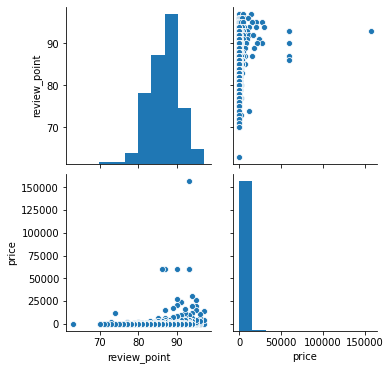

In [23]:
sns.pairplot(scotch_df);

There seems to be a number of outliers in price, which make these visualizations hard to read. 

I could altogether drop them, because these specific whiskies are unobtainable for the vast majorty of whisky drinkers anyway and therefore not useful for the intention of this project. But that seemed a significant number of entries to drop, well over 100.

Instead, I opted to try out two different model sets, one that cuts outliers with a price of one thousand dollars or more, and another that raises the cutoff to five thousand.

In [0]:
scotch_1000=scotch_df.drop(scotch_df.loc[scotch_df['price'] > 1000.000000].index)
scotch_5000=scotch_df.drop(scotch_df.loc[scotch_df['price'] > 5000.000000].index)

###EDA Visualizations for Scotch_1000

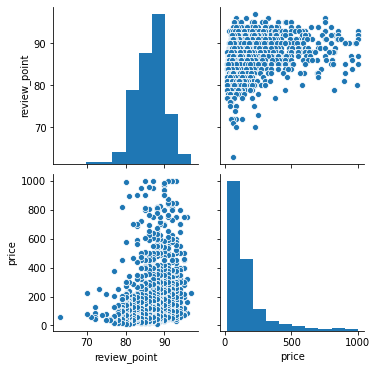

In [25]:
sns.pairplot(scotch_1000);

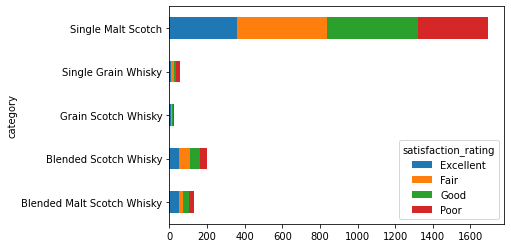

In [26]:
satisfaction_type = pd.crosstab(scotch_1000['category'], scotch_1000['satisfaction_rating'])
satisfaction_type.plot(kind='barh', stacked=True);

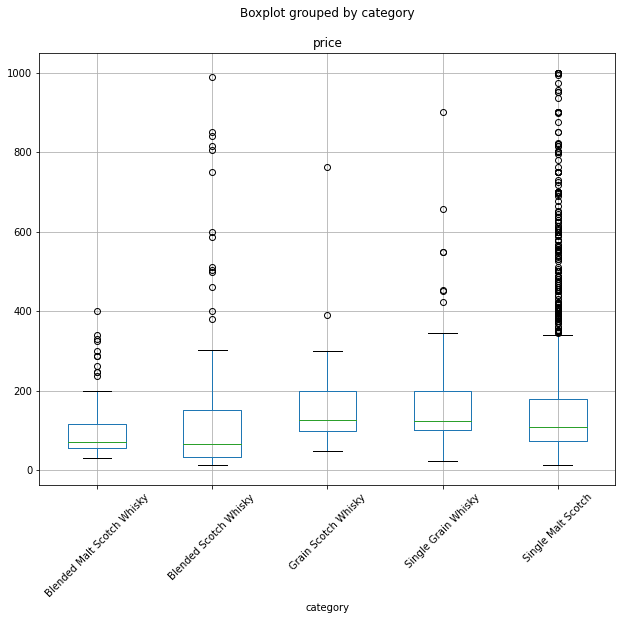

In [27]:
scotch_1000.boxplot(column='price', by='category', rot=45, figsize=(10,8));

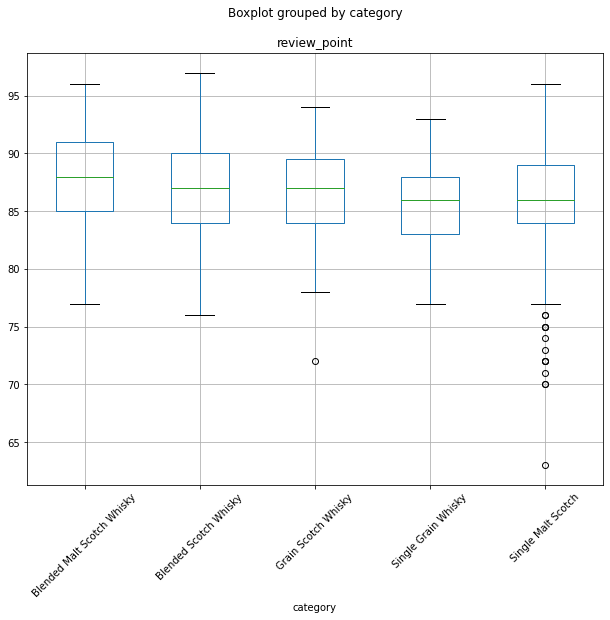

In [28]:
scotch_1000.boxplot(column='review_point', by='category', rot=45, figsize=(10,8));

I noticed here that the first four boxes are similar, but Single Malt Scotch seems to have a disproportionately high number of outliers. Generally speaking, when people think of scotch they think of single malts. Perhaps there is just a disproportionately larger amount of these in our dataset to begin with? Looking at the original dataset, I got the following results:

In [29]:
scotch_df['category'].value_counts()

Single Malt Scotch            1819
Blended Scotch Whisky          211
Blended Malt Scotch Whisky     132
Single Grain Whisky             57
Grain Scotch Whisky             28
Name: category, dtype: int64

Single Malts are almost nine times as numerous as the next largest category, Blended Scotch. That probably accounts for it.

In this case, I used the original scotch_df to see the distribution of categories, but I also wanted to see how it changed for scotch_1000 and scotch_5000. It looks like the majority of high-cost scotched were also Single Malts.

In [30]:
scotch_1000['category'].value_counts()

Single Malt Scotch            1694
Blended Scotch Whisky          201
Blended Malt Scotch Whisky     130
Single Grain Whisky             55
Grain Scotch Whisky             27
Name: category, dtype: int64

In [31]:
scotch_5000['category'].value_counts()

Single Malt Scotch            1783
Blended Scotch Whisky          210
Blended Malt Scotch Whisky     132
Single Grain Whisky             57
Grain Scotch Whisky             28
Name: category, dtype: int64

###EDA Visualizations for Scotch_5000

I was curious to see how these same visualizations might change due to the raised cutoff for outlier values.

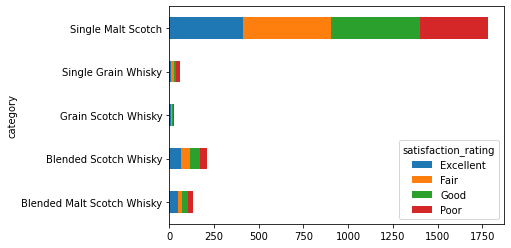

In [32]:
satisfaction_type = pd.crosstab(scotch_5000['category'], scotch_5000['satisfaction_rating'])
satisfaction_type.plot(kind='barh', stacked=True);

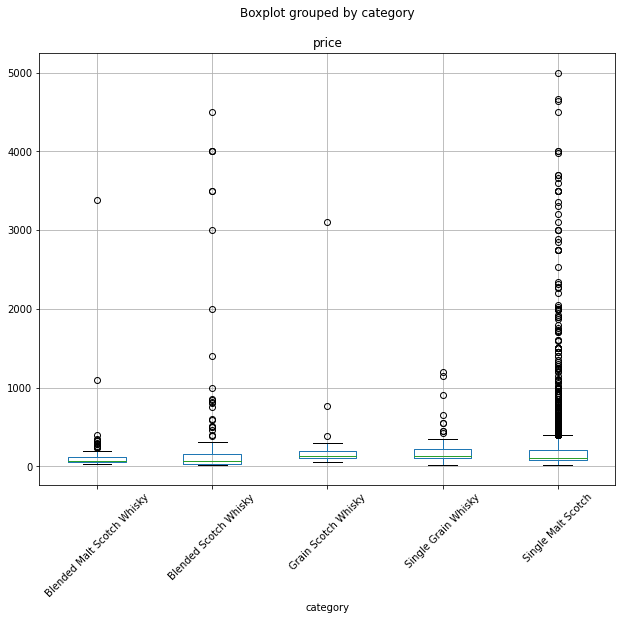

In [33]:
scotch_5000.boxplot(column='price', by='category', rot=45, figsize=(10,8));

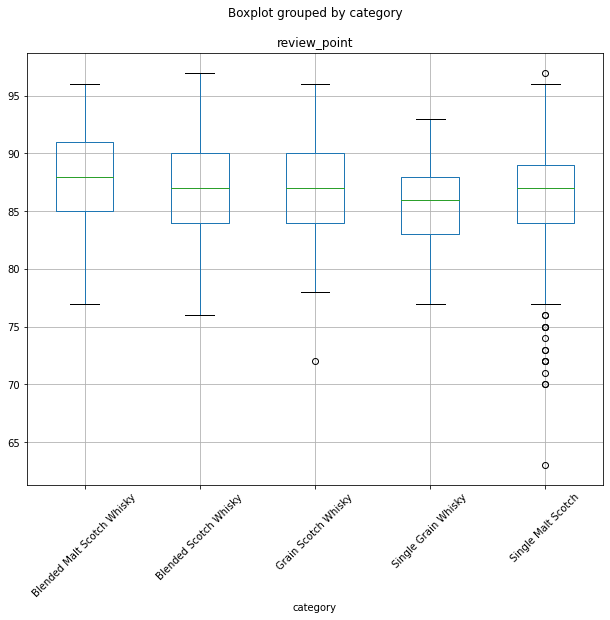

In [34]:
scotch_5000.boxplot(column='review_point', by='category', rot=45, figsize=(10,8));

The first and third visualizations did not change by much, but we can see how much the outliers affect the price to category box-plot comparison.

#Train/Val/Test Split

*Note: here on out I will be primarily using the created scotch_1000 dataset, except where otherwise noted.*

In [35]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(scotch_1000, train_size=0.80, test_size=0.20, stratify=scotch_1000['satisfaction_rating'], random_state=55)

train.shape, test.shape

((1685, 7), (422, 7))

Here, I opted to split the data into just training and test datasets. I will be using cross validation in my pipeline, which will provide my validation data. 

In [36]:
train['satisfaction_rating'].value_counts(normalize=True)

Good         0.282493
Fair         0.271810
Excellent    0.228487
Poor         0.217211
Name: satisfaction_rating, dtype: float64

The satisfaction rating value_counts (normalized) are similar to what was represented by the original dataset. There is some difference, which is to be expected, but it is marginally skewed towards more Good, Fair, and Poor ratings and less Excellent ratings.

If we were to look at our training dataset alone, our majority class does not change it's class, but it does increase to 28.25%.

In [0]:
# train/val split for use with Logistic Regression and Random Forest without
# cross validation
trainLR, val = train_test_split(train, train_size=0.80, test_size=0.20, stratify=train['satisfaction_rating'], random_state=55)

##Feature Engineering

Two common characteristics of whiskies that are often sought are the alcohol by volume, or ABV, and whether or not the whisky has an age statement. Neither of these two are represented by a feature on their own, but are rather included in the name feature of the original dataset. 

I extracted both of these characteristics and put them into thier own features. While ABV is required by law to be on the label (and is therefore included in each entry), age statements are not. Furthermore, not all whiskies have an identifiable age to state. In the cases where age statement was missing, I gave it a value of "No Age Statement".

In [0]:
def wrangle(X):
  ''' Wrangle train and test sets in the same way'''

  # Prevent SettingWithCopyWarning
  X = X.copy()

  # Currency is the same value for every entry, giving us no actionable information.
  # Drop review_point to prevent data leakage with the satisfaction_rating feature
  X=X.drop(columns=['currency', 'review_point'])

  # Extract the ABV from the name feature and put it into a new feature
  X['alcohol_by_volume']=X['name'].str.extract(pat = '([0-9][0-9.]+%)')
  X['alcohol_by_volume'] = X['alcohol_by_volume'].str.strip('%').astype(float)

  # Extract from name feature if there is an age statement
  X['age']=X['name'].str.extract(pat = '([0-9][0-9] year)')
  X['age']=X['age'].fillna('No Age Statement')

  # Return wrangled dataframe
  return X

train = wrangle(train)
test = wrangle(test)
trainLR = wrangle(trainLR)
val = wrangle(val)

In [39]:
# The target is the satisfaction_rating feature
target = 'satisfaction_rating'

# Get a dataframe with all train features except target
train_features = train.drop(columns=[target])

# Get a list of numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of nonnumeric features, then a list of all
# with a cardinality <=225
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality<=225].index.tolist()

# Combine lists
features = numeric_features + categorical_features
print(features)

['price', 'alcohol_by_volume', 'category', 'age']


In [0]:
# Arrange data into X feature matrix and y target vector
X_train = train[features]
X_test = test[features]
y_train=train[target]
y_test=test[target]

X_trainLR=trainLR[features]
X_val=val[features]
y_trainLR=trainLR[target]
y_val=val[target]

In [41]:
X_train.shape

(1685, 4)

###Permutation Importance

Even though I only have four features, I decided to run a Permutation Importance as a just-in-case sort of thing.

In [42]:
# transform train data for use with eli5 library's PermutationImportance
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

transformers = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)
X_trainLR_transformed = transformers.fit_transform(X_trainLR)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_trainLR_transformed, y_trainLR)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [43]:
# import, instantiate, and fit permuter
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [111]:
feature_names = X_val.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.0623 ± 0.0168,price
0.0552 ± 0.0245,alcohol_by_volume
0.0344 ± 0.0233,age
0.0071 ± 0.0264,category


#Logistic Regression

My linear model utilizes Logistic Regression to predict the satisfaction rating of the test observations. Unlinke my later models, I needed to split the training data into training and validation datasets. I chose to split these randomly at 80%/20% train/validation. 

##Model Pipeline: Logistic Regression

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

LR_pipe = make_pipeline(ce.OneHotEncoder(use_cat_names=True),
                         SimpleImputer(), StandardScaler(),
                        LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1))

LR_pipe.fit(X_trainLR, y_trainLR)
print(f'Train accuracy: {LR_pipe.score(X_trainLR, y_trainLR)}')
print(f'Validation accuracy: {LR_pipe.score(X_val, y_val)}')

Train accuracy: 0.3879821958456973
Validation accuracy: 0.31750741839762614


##Logistic Regression Evaluation

In [47]:
from sklearn.metrics import accuracy_score

y_pred_LR = LR_pipe.predict(X_test)
print(f'Prediction accuracy: {accuracy_score(y_test, y_pred_LR)}')

Prediction accuracy: 0.3033175355450237


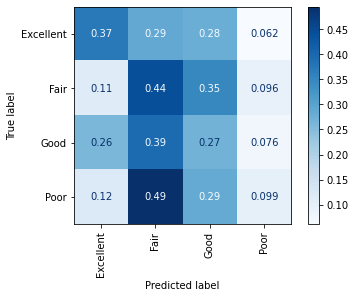

In [48]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(LR_pipe, X_test, y_test, normalize='true',
                      xticks_rotation='vertical', cmap='Blues');

In [49]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_LR))

              precision    recall  f1-score   support

   Excellent       0.40      0.37      0.38        97
        Fair       0.30      0.44      0.36       115
        Good       0.26      0.27      0.26       119
        Poor       0.26      0.10      0.14        91

    accuracy                           0.30       422
   macro avg       0.30      0.30      0.29       422
weighted avg       0.30      0.30      0.29       422



#Random Forest Classification with Cross Validation

For my tree-based model, I decided to utilize a Random Forest with Cross Validation. This classification model is ideal for this useage due to the multi-class nature of the classification. It also allows for a more accurate model compared to a single Decision Tree model. 

Because of the use of cross validation, the training dataset did not need to be split into train and validation datasets.

##Model Pipeline: Random Forest with Cross Validation


In [50]:
# Make a pipeline for the model
from sklearn.model_selection import cross_val_score

CVRF_pipe = make_pipeline(ce.ordinal.OrdinalEncoder(),
                          SimpleImputer(strategy='median'),
                          RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=55)
                          )

k=18
scores = cross_val_score(CVRF_pipe, X_train, y_train, cv=k, scoring='accuracy')
print(f'Accuracy for {k} folds:', scores)

Accuracy for 18 folds: [0.25531915 0.30851064 0.36170213 0.30851064 0.32978723 0.39361702
 0.34042553 0.38297872 0.38297872 0.38297872 0.34042553 0.31182796
 0.30107527 0.3655914  0.2688172  0.34408602 0.35483871 0.32258065]


In [51]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    CVRF_pipe, 
    param_distributions=param_distributions, 
    n_iter=25, 
    cv=5, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  1.5min finished


In [52]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').T

,13,7,20,2,10,18,1,4,19,17,16,12,22,15,0,8,14,3,5,23,9,24,21,11,6
mean_fit_time,1.38622,0.845195,0.278192,1.33907,0.713538,0.619629,0.529741,0.6283,1.78042,1.93463,1.12187,1.37764,2.14136,0.516472,1.72229,0.860177,0.63306,0.96087,1.18611,0.688606,0.347103,1.28086,2.0431,1.52805,0.365228
std_fit_time,0.0374363,0.0388066,0.0120276,0.0565739,0.0373995,0.0220537,0.0502293,0.0105829,0.0354881,0.0432448,0.0373179,0.0445128,0.0464085,0.00985373,0.094769,0.0168252,0.0114703,0.0402391,0.0420786,0.0350914,0.0376039,0.125276,0.0264924,0.0391355,0.0175522
mean_score_time,0.209557,0.107913,0.109611,0.210093,0.109107,0.109084,0.110336,0.108837,0.208428,0.212335,0.128851,0.12927,0.209347,0.10974,0.208915,0.110053,0.109619,0.10831,0.149777,0.110986,0.11056,0.109953,0.211849,0.152321,0.109564
std_score_time,0.000404568,0.000953719,0.00129014,0.000978876,0.00244548,0.00171228,0.0013334,0.002772,0.00154558,0.00358678,0.0392697,0.0406539,0.00170649,0.0012257,0.000890982,0.00105849,0.00186316,0.000712058,0.0501227,0.000675754,0.00272567,0.00217438,0.00152477,0.0521089,0.00218871
param_randomforestclassifier__max_depth,10,5,10,15,10,10,10,15,15,10,None,15,None,None,None,20,None,None,20,None,None,20,20,None,None
param_randomforestclassifier__max_features,0.208209,0.610631,0.0624541,0.0348927,0.37863,0.65322,0.500297,0.00146471,0.0583112,0.817638,0.368729,0.574548,0.680204,0.363377,0.74824,0.650933,0.0584825,0.0848539,0.28255,0.799324,0.965017,0.809666,0.897721,0.974552,0.88093
param_randomforestclassifier__n_estimators,417,261,74,361,206,158,134,147,483,467,282,318,477,126,376,196,156,230,295,134,66,265,420,304,61
param_simpleimputer__strategy,mean,median,mean,median,median,median,median,median,mean,mean,median,median,median,median,median,mean,median,mean,mean,mean,mean,mean,median,median,median
params,"{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r..."
split0_test_score,0.364985,0.353116,0.356083,0.379822,0.356083,0.347181,0.356083,0.37092,0.376855,0.341246,0.356083,0.341246,0.350148,0.347181,0.353116,0.35905,0.353116,0.347181,0.362018,0.335312,0.305638,0.338279,0.320475,0.320475,0.305638


##Random Forest with CV Evaluation

In [53]:
CV_best_pipe = search.best_estimator_

y_pred_RF = CV_best_pipe.predict(X_test)
print(f'Validation accuracy for {k} folds:', scores)
print(f'Prediction accuracy: {accuracy_score(y_test, y_pred_RF)}')

Validation accuracy for 18 folds: [0.25531915 0.30851064 0.36170213 0.30851064 0.32978723 0.39361702
 0.34042553 0.38297872 0.38297872 0.38297872 0.34042553 0.31182796
 0.30107527 0.3655914  0.2688172  0.34408602 0.35483871 0.32258065]
Prediction accuracy: 0.3459715639810427


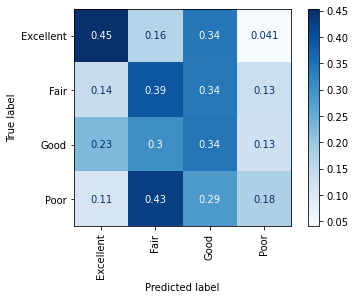

In [54]:
plot_confusion_matrix(CV_best_pipe, X_test, y_test, normalize='true',
                      xticks_rotation='vertical', cmap='Blues');

In [55]:
print(classification_report (y_test, y_pred_RF))

              precision    recall  f1-score   support

   Excellent       0.45      0.45      0.45        97
        Fair       0.33      0.39      0.36       115
        Good       0.29      0.34      0.32       119
        Poor       0.32      0.18      0.23        91

    accuracy                           0.35       422
   macro avg       0.35      0.34      0.34       422
weighted avg       0.35      0.35      0.34       422



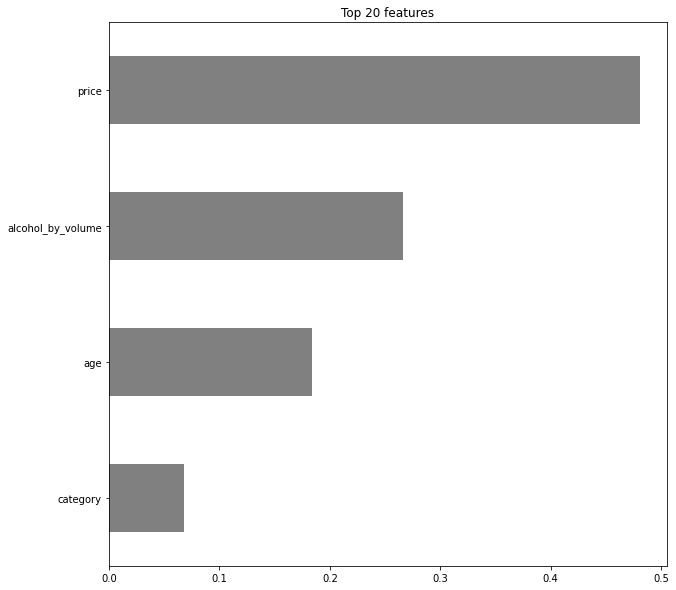

In [56]:
# Get feature importances
rf = CV_best_pipe.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

# Random Forest Classification using Train/Val split

I was curious to see if the Cross Validation performed better than my own Train/Val split, so I also ran the model this way.

##Model Pipeline: Random Forest Train/Val Split

In [57]:
# first, run the pipeline on the train/val split
RF_pipe = make_pipeline(ce.ordinal.OrdinalEncoder(),
                        SimpleImputer(),
                        RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=55)
                        )

RF_pipe.fit(X_trainLR, y_trainLR)
print(f'Train accuracy: {RF_pipe.score(X_trainLR, y_trainLR)}')
print(f'Validation accuracy: {RF_pipe.score(X_val, y_val)}')

Train accuracy: 0.913946587537092
Validation accuracy: 0.32344213649851633


In [58]:
# then fit it back to the full training data set
RF_pipe = make_pipeline(ce.ordinal.OrdinalEncoder(),
                        SimpleImputer(),
                        RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=55)
                        )

RF_pipe.fit(X_train, y_train)
print(f'Train (full dataset) accuracy: {RF_pipe.score(X_train, y_train)}')

Train (full dataset) accuracy: 0.9014836795252226


##Random Forest Train/Val Split Evaluation

In [59]:
y_pred_RFSplit = RF_pipe.predict(X_test)
print(f'Prediction accuracy: {accuracy_score(y_test, y_pred_RFSplit)}')

Prediction accuracy: 0.3175355450236967


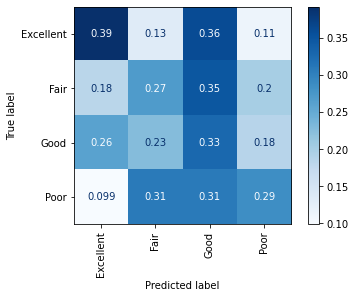

In [60]:
plot_confusion_matrix(RF_pipe, X_test, y_test, normalize='true',
                      xticks_rotation='vertical', cmap='Blues');

In [61]:
print(classification_report(y_test, y_pred_RFSplit))

              precision    recall  f1-score   support

   Excellent       0.38      0.39      0.39        97
        Fair       0.31      0.27      0.29       115
        Good       0.27      0.33      0.30       119
        Poor       0.32      0.29      0.30        91

    accuracy                           0.32       422
   macro avg       0.32      0.32      0.32       422
weighted avg       0.32      0.32      0.32       422



#XGBoost Classifier

##Model Pipeline: XGBoost Classifier

In [0]:
from xgboost import XGBClassifier
encoder = ce.ordinal.OrdinalEncoder()
X_trainLR_encoded = encoder.fit_transform(X_trainLR)
X_val_encoded = encoder.transform(X_val)

XGBmodel = XGBClassifier(
    n_estimators=1000, # upper threshold
    max_depth=3, # use higher values if dealing with a lot of high-cardinality features
    learning_rate=0.5,
    n_jobs=-1
)

##XGBoost Classifier Evaluation

In [74]:
eval_set = [(X_trainLR_encoded, y_trainLR), (X_val_encoded, y_val)]
XGBmodel.fit(X_trainLR_encoded, 
          y_trainLR, 
          eval_set=eval_set, 
          eval_metric='merror',
          early_stopping_rounds=50) # stop if the score hasn't improved in 50 rounds/iterations

[0]	validation_0-merror:0.600148	validation_1-merror:0.670623
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.580861	validation_1-merror:0.682493
[2]	validation_0-merror:0.568249	validation_1-merror:0.67359
[3]	validation_0-merror:0.554896	validation_1-merror:0.679525
[4]	validation_0-merror:0.555638	validation_1-merror:0.688427
[5]	validation_0-merror:0.551187	validation_1-merror:0.670623
[6]	validation_0-merror:0.555638	validation_1-merror:0.664688
[7]	validation_0-merror:0.545994	validation_1-merror:0.667656
[8]	validation_0-merror:0.533383	validation_1-merror:0.661721
[9]	validation_0-merror:0.526706	validation_1-merror:0.658754
[10]	validation_0-merror:0.525223	validation_1-merror:0.655786
[11]	validation_0-merror:0.512611	validation_1-merror:0.652819
[12]	validation_0-merror:0.506677	validation_1-merror:0.664688
[13]	validation_0-merror:0.50

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

#Partial Dependency Plots

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot, pdp_isolate, pdp_plot

In [0]:
X_test=X_test.fillna(method='ffill')

In [0]:
features = ['price','alcohol_by_volume']

interact = pdp_interact(
    model=CV_best_pipe,
    dataset=X_test,
    model_features=X_test.columns,
    features=features
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


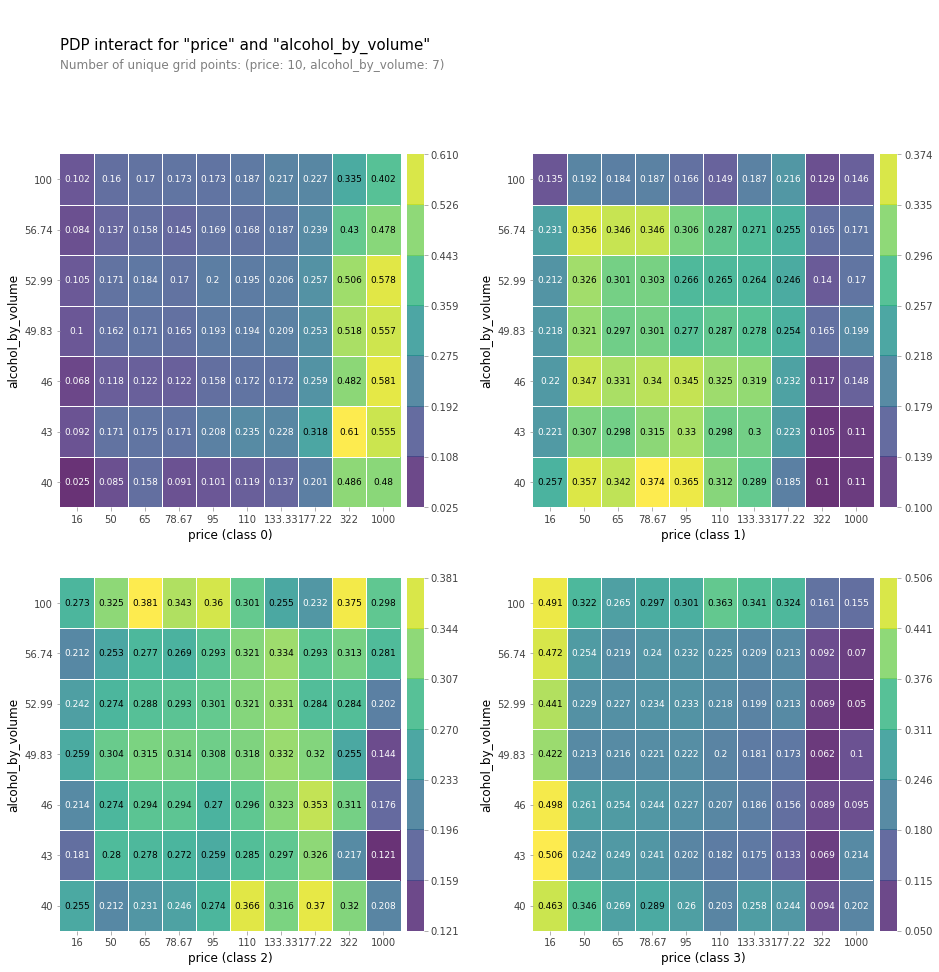

In [95]:
pdp_interact_plot(interact, plot_type='grid', feature_names=features);

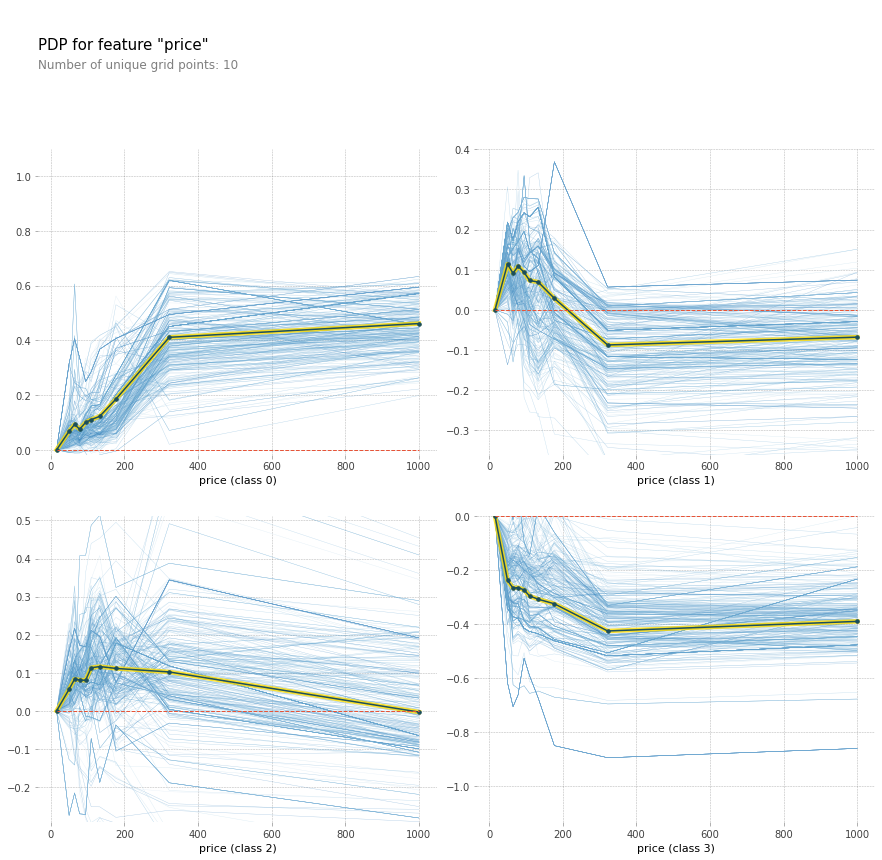

In [107]:
feature = 'price'

isolated = pdp_isolate(
    model=CV_best_pipe,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature, plot_lines=True);


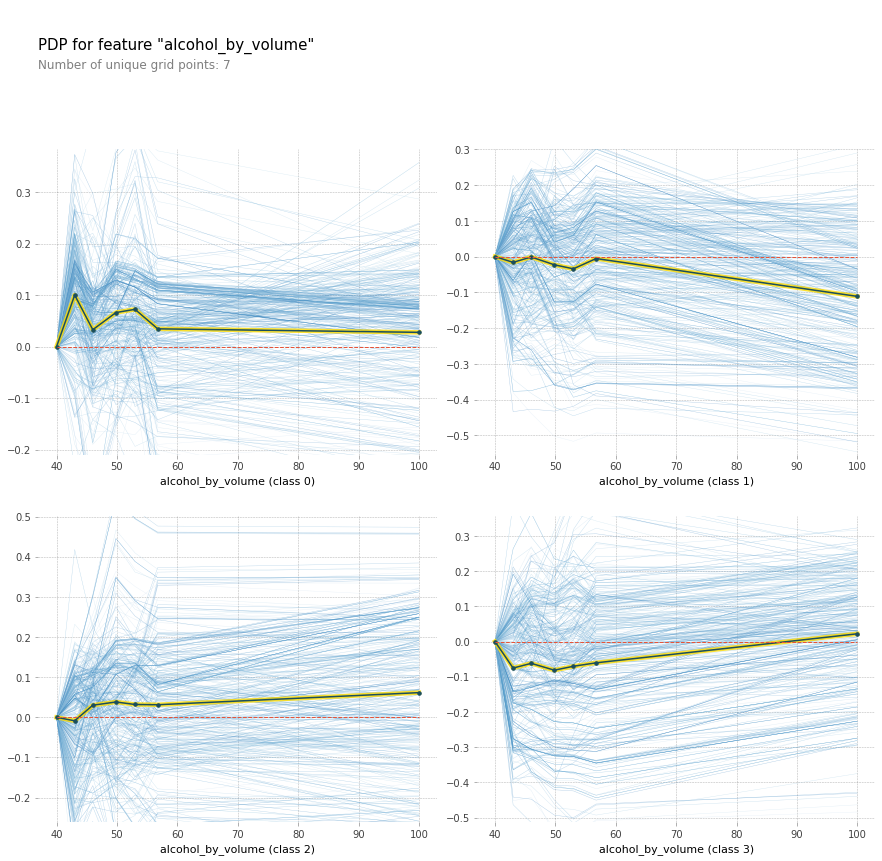

In [108]:
feature = 'alcohol_by_volume'

isolated = pdp_isolate(
    model=CV_best_pipe,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature, plot_lines=True);